<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/MeteoBale/MeteoBale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Chargement des données

In [2]:
!rm *.zip
!rm *.csv
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip?raw=true"
!unzip MeteoBale.zip

rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.csv': No such file or directory
--2021-05-15 16:03:18--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip [following]
--2021-05-15 16:03:18--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/MeteoBale.zip [following]
--2021-05-15 16:03:18--  https://raw.githubusercontent.c

In [3]:
# Création de la série sous Pandas
df_complet = pd.read_csv("MeteoBale.csv",delimiter=";",decimal=",")
df_complet

,timestamp,Bale Temperature [2 m elevation corrected],Bale Precipitation Total,Bale Relative Humidity [2 m],Bale Wind Speed [10 m],Bale Wind Direction [10 m],Bale Cloud Cover Total,Bale Sunshine Duration,Bale Shortwave Radiation,Bale Mean Sea Level Pressure [MSL]
0,2010-01-01T00:00:00,7.180529,0.0,83,5.692099,124.695150,100.0,0.0,0.0,993.1
1,2010-01-01T01:00:00,6.570528,0.0,86,6.618519,112.380135,100.0,0.0,0.0,993.1
2,2010-01-01T02:00:00,5.680529,0.0,92,7.072878,104.743550,100.0,0.0,0.0,992.6
3,2010-01-01T03:00:00,4.570528,0.0,95,7.862518,105.945400,99.0,0.0,0.0,992.1
4,2010-01-01T04:00:00,4.100529,0.0,94,7.172949,107.525570,82.0,0.0,0.0,991.2
...,...,...,...,...,...,...,...,...,...,...
96451,2021-01-01T19:00:00,1.970529,0.0,85,18.003600,358.854250,100.0,0.0,0.0,1007.9
96452,2021-01-01T20:00:00,1.730529,0.0,85,16.203999,358.727000,100.0,0.0,0.0,1008.0
96453,2021-01-01T21:00:00,1.520529,0.0,86,13.679999,360.000000,100.0,0.0,0.0,1008.1
96454,2021-01-01T22:00:00,1.120529,0.0,90,10.446206,358.025100,100.0,0.0,0.0,1008.4


In [4]:
df_complet.dtypes

timestamp                                      object
Bale Temperature [2 m elevation corrected]    float64
Bale Precipitation Total                      float64
Bale Relative Humidity [2 m]                    int64
Bale Wind Speed [10 m]                        float64
Bale Wind Direction [10 m]                    float64
Bale Cloud Cover Total                        float64
Bale Sunshine Duration                        float64
Bale Shortwave Radiation                      float64
Bale Mean Sea Level Pressure [MSL]            float64
dtype: object

In [5]:
df_complet.iloc[:,1:] = df_complet.iloc[:,1:].astype(np.float32)
df_complet.index = pd.to_datetime(df_complet['timestamp'],yearfirst=True)
df_complet = df_complet.drop(columns=['timestamp'])
df_complet

,Bale Temperature [2 m elevation corrected],Bale Precipitation Total,Bale Relative Humidity [2 m],Bale Wind Speed [10 m],Bale Wind Direction [10 m],Bale Cloud Cover Total,Bale Sunshine Duration,Bale Shortwave Radiation,Bale Mean Sea Level Pressure [MSL]
timestamp,,,,,,,,,
2010-01-01 00:00:00,7.180529,0.0,83.0,5.692099,124.695152,100.0,0.0,0.0,993.099976
2010-01-01 01:00:00,6.570529,0.0,86.0,6.618519,112.380135,100.0,0.0,0.0,993.099976
2010-01-01 02:00:00,5.680529,0.0,92.0,7.072878,104.743553,100.0,0.0,0.0,992.599976
2010-01-01 03:00:00,4.570529,0.0,95.0,7.862518,105.945396,99.0,0.0,0.0,992.099976
2010-01-01 04:00:00,4.100529,0.0,94.0,7.172949,107.525574,82.0,0.0,0.0,991.200012
...,...,...,...,...,...,...,...,...,...
2021-01-01 19:00:00,1.970529,0.0,85.0,18.003599,358.854248,100.0,0.0,0.0,1007.900024
2021-01-01 20:00:00,1.730529,0.0,85.0,16.203999,358.726990,100.0,0.0,0.0,1008.000000
2021-01-01 21:00:00,1.520529,0.0,86.0,13.679999,360.000000,100.0,0.0,0.0,1008.099976


In [6]:
df_soleil = df_complet["Bale Shortwave Radiation"]
df_soleil

timestamp
2010-01-01 00:00:00    0.0
2010-01-01 01:00:00    0.0
2010-01-01 02:00:00    0.0
2010-01-01 03:00:00    0.0
2010-01-01 04:00:00    0.0
                      ... 
2021-01-01 19:00:00    0.0
2021-01-01 20:00:00    0.0
2021-01-01 21:00:00    0.0
2021-01-01 22:00:00    0.0
2021-01-01 23:00:00    0.0
Name: Bale Shortwave Radiation, Length: 96456, dtype: float32

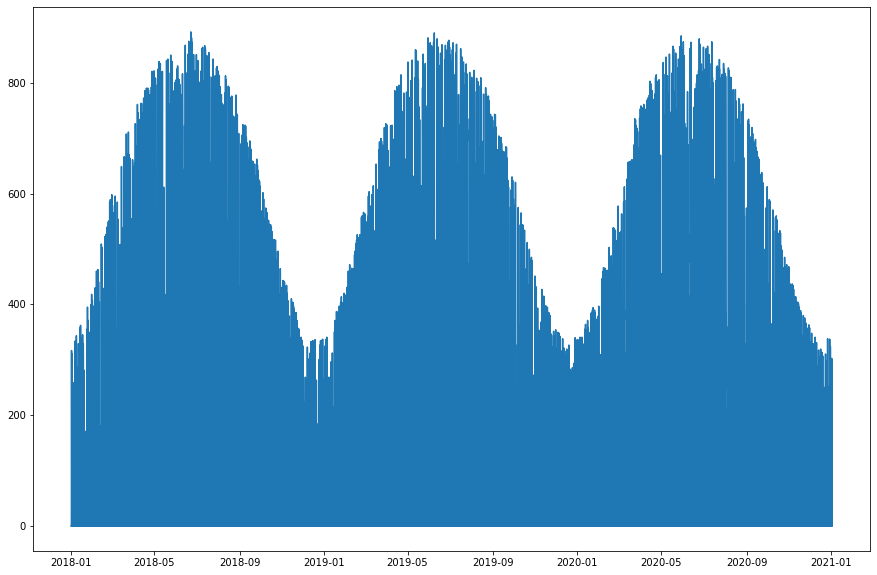

In [7]:
date_debut = "2018-01-01 00:00:00"
date_fin = "2021-01-01 23:00:00"

df_etude = df_soleil.loc[date_debut:date_fin]

f1, ax = plt.subplots(1, 1, figsize=(15, 10))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

ax.plot(df_etude.index, df_etude.values)


# Recherche et correction des données manquantes et des anomalies

On commence par rechercher combien de données sont manquantes dans chaque colonne sur l'intervalle choisi :

In [10]:
data_manquantes = sum(np.isnan(df_etude))
print ("Données manquantes : %s" %data_manquantes)


Données manquantes : 0


Les anomalies sont fréquentes dans les séries temporelles, et la performance des prédictions est souvent améliorée lorsque ces anomalies sont traitées.  
Pour avoir un apperçu de ces éventuelles anomalies, nous allons utiliser la méthode ["Isolation Forest"](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) disponnible dans Scikit-learn.  

Les paramètres utilisés sont les suivants :
 - **n_estimators** : C'est le nombre de sous-groupes d'échantillons à utiliser. Une valeur de 128 ou 256 est préconnisée dans le document de recherche.
 - **max_samples** : C'est le nombre d'échantillons maximum à utiliser. Nous utiliserons l'ensemble des échantillons.
 - **max_features** :  C'est le nombre de motifs aléatoirement choisis sur chaque noeud de l'arbre. Nous choisirons un seul motif.
 - **contamination** : C'est le pourcentage estimé d'anomalies dans les données. Ce paramètre permet de régler la sensibilité de l'algorithme. On va commencer avec 5% et affiner si nécessaire par la suite.

In [11]:
# Initialise le modèle
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=256,max_samples=df_etude.size, contamination=0.01,max_features=1, verbose=1)
clf.fit(df_etude.values.reshape(-1,1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1, max_samples=26328, n_estimators=256,
                n_jobs=None, random_state=None, verbose=1, warm_start=False)

In [12]:
# Réalise les prédictions
pred = clf.predict(df_etude.values.reshape(-1,1))
pred

array([1, 1, 1, ..., 1, 1, 1])

In [184]:
np.count_nonzero(pred < 0)

261

In [142]:
# Ajoute une colonne "Anomalie" dans la série
df_etude['Anomalies'] = pred
df_etude['Anomalies'] = df_etude['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)

# Affiche les informations sur les anomalies
print(df_etude['Anomalies'].value_counts())

AttributeError: ignored

# Analyse de la série

**1. ACF & PACF**

Text(0.5, 1.0, 'Autocorrélation partielle')

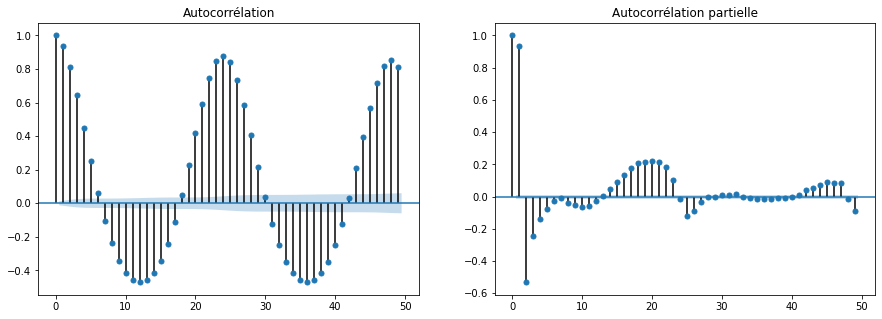

In [13]:
# ACF & PACF du bruit blanc

serie = df_etude

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation")

plot_pacf(serie, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle")

**2. Test de Dickey-Fuller**

In [14]:
import statsmodels.api as sm

serie_test = serie

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -8.640302392335455
p-value: 5.4488697936909086e-14,
N: 26278, 
critical values: {'1%': -3.4305988750628025, '5%': -2.8616499954783987, '10%': -2.5668285473360037}


# Préparation des datasets

**1. Séparation des données en données pour l'entrainement et la validation**

In [8]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement = df_etude.iloc[:temps_separation]
serie_test = df_etude.iloc[temps_separation:]

print("Taille de l'entrainement : %d" %len(serie_entrainement))
print("Taille de la validation : %d" %len(serie_test))

Taille de l'entrainement : 21062
Taille de la validation : 5266


In [9]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(serie_entrainement))
std = tf.math.reduce_std(np.asarray((serie_entrainement)))

# Normalisation des données
serie_entrainement = (serie_entrainement-mean)/std
serie_test = (serie_test-mean)/std

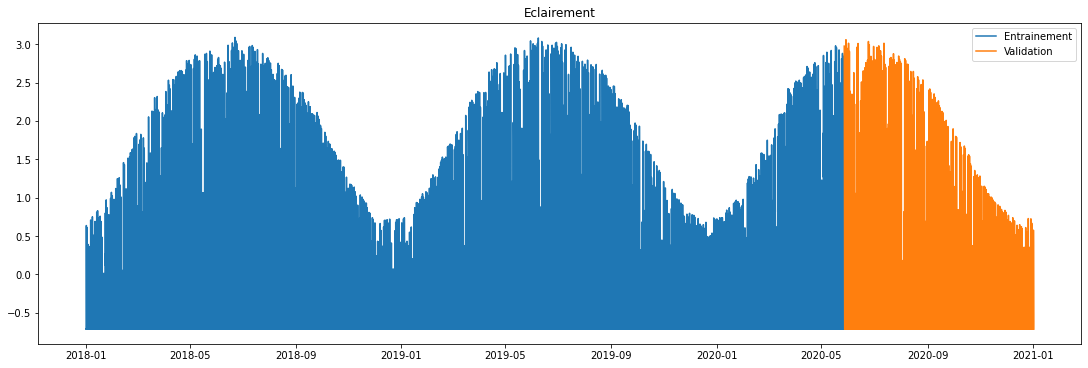

In [10]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
ax.plot(serie_entrainement, label="Entrainement")
ax.plot(serie_test,label="Validation")

ax.set_title("Eclairement")

ax.legend()
plt.show()

**2. Création des datasets**

In [11]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(serie, taille_fenetre, horizon, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + horizon))
  dataset = dataset.map(lambda x: (tf.expand_dims(x[0:taille_fenetre],axis=1),x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [12]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 7
horizon = 1
batch_size = 512

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement,taille_fenetre,horizon,batch_size)
dataset_val = prepare_dataset_XY(serie_test,taille_fenetre,horizon,batch_size)

In [13]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

41
(512, 7, 1)
(512, 1)


On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [14]:
# Extrait les X,Y du dataset
#56x((1000,4,1),(1000,1)) => (56*1000,4,1) ; (56*1000,1)

x,y = tuple(zip(*dataset))

# Recombine les données
# (56,1000,4,1) => (56*128,4,1)
# (56,1000,1) => (56*128,1)
x_train = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_train = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

(20992, 7, 1)
(20992,)


Puis la même chose pour les données de validation :

In [15]:
# Extrait les X,Y du dataset_val

x,y = tuple(zip(*dataset_val))

# Recombine les données

x_val = np.asarray(tf.reshape(np.asarray(x,dtype=np.float32),shape=(np.asarray(x).shape[0]*np.asarray(x).shape[1],taille_fenetre,1)))
y_val = np.asarray(tf.reshape(np.asarray(y,dtype=np.float32),shape=(np.asarray(y).shape[0]*np.asarray(y).shape[1])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

(5120, 7, 1)
(5120,)


# Création du modèle LSTM de type encodeur-décodeur

**1. Création du réseau**

Par défaut, la dimension des vecteurs cachés est de 10 et aucune régularisation n'est utilisée.

In [19]:
dim_LSTM = 32
l1_reg = 0.0
l2_reg = 0.0

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre,1),batch_size=batch_size)

# Encodeur
s_encodeur = tf.keras.layers.LSTM(dim_LSTM, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(entrees)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(512, 7, 1)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (512, 32)            4352        input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (512, 32)            1056        lstm_1[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (512, 64)            0           dense_2[0][0]                    
                                                                 lstm_1[0][0]               

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [20]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

Epoch 1/100
41/41 [==============================] - 2s 13ms/step - loss: 1.1213 - mse: 1.1213

Epoch 00001: loss improved from inf to 1.12809, saving model to poids.hdf5
Epoch 2/100
41/41 [==============================] - 1s 13ms/step - loss: 1.1240 - mse: 1.1240

Epoch 00002: loss improved from 1.12809 to 1.12809, saving model to poids.hdf5
Epoch 3/100
41/41 [==============================] - 1s 13ms/step - loss: 1.1280 - mse: 1.1280

Epoch 00003: loss improved from 1.12809 to 1.12808, saving model to poids.hdf5
Epoch 4/100
41/41 [==============================] - 0s 12ms/step - loss: 1.1356 - mse: 1.1356

Epoch 00004: loss improved from 1.12808 to 1.12808, saving model to poids.hdf5
Epoch 5/100
41/41 [==============================] - 0s 12ms/step - loss: 1.1477 - mse: 1.1477

Epoch 00005: loss improved from 1.12808 to 1.12808, saving model to poids.hdf5
Epoch 6/100
41/41 [==============================] - 1s 12ms/step - loss: 1.1249 - mse: 1.1249

Epoch 00006: loss improved from 1

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

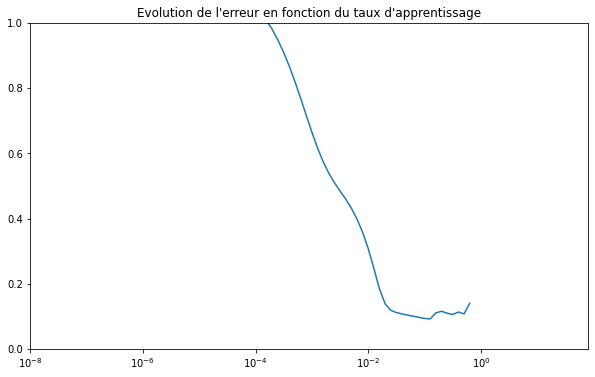

In [22]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [23]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [24]:
max_periodes = 500

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

 
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle, avec une réduction des calculs du gradient
historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-4,periodes = 10, term="loss")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
#historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-8,periodes = 10, term="val_My_MSE")])


Epoch 1/500
41/41 [==============================] - 4s 40ms/step - loss: 0.0921 - mse: 0.0921 - val_loss: 0.0813 - val_mse: 0.0813

Epoch 00001: loss improved from inf to 0.08656, saving model to poids_train.hdf5
Epoch 2/500
41/41 [==============================] - 1s 15ms/step - loss: 0.0804 - mse: 0.0804 - val_loss: 0.0770 - val_mse: 0.0770

Epoch 00002: loss improved from 0.08656 to 0.07518, saving model to poids_train.hdf5
Epoch 3/500
41/41 [==============================] - 1s 16ms/step - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0751 - val_mse: 0.0751

Epoch 00003: loss improved from 0.07518 to 0.07071, saving model to poids_train.hdf5
Epoch 4/500
41/41 [==============================] - 1s 16ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0778 - val_mse: 0.0778

Epoch 00004: loss improved from 0.07071 to 0.06889, saving model to poids_train.hdf5
Epoch 5/500
41/41 [==============================] - 1s 14ms/step - loss: 0.0711 - mse: 0.0711 - val_loss: 0.0740 - val_mse: 0.0740


In [25]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

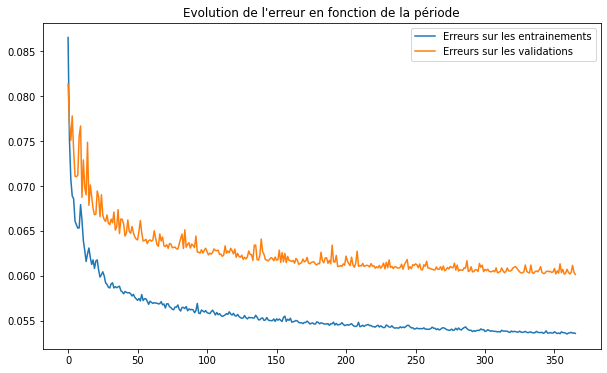

In [26]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [27]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


10/10 [==============================] - 1s 65ms/step - loss: 0.0607 - mse: 0.0607


[0.06071098893880844, 0.06071098893880844]

#Prédictions

In [28]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(dataset)
pred_val = model.predict(dataset_val)

In [29]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
serie = np.concatenate([serie_entrainement,serie_test])
index = np.linspace(0,len(serie)-1,len(serie),dtype=np.int16)
fig.add_trace(go.Scatter(x=index,y=serie,line=dict(color='blue', width=1),name="Série oroginale"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=index[taille_fenetre:],y=pred_ent[:,0],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=index[temps_separation+taille_fenetre:],y=pred_val[:,0],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Création du modèle LSTM avec CNN


**1. Création du réseau**

In [16]:
dim_LSTM = 32

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)


# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
e_cnn = tf.keras.layers.Conv1D(filters=dim_LSTM,kernel_size=3, strides=1, padding="causal", activation="relu")(e_adapt)
e_cnn = tf.keras.layers.Dropout(0.0)(e_cnn)
s_encodeur = tf.keras.layers.LSTM(dim_LSTM)(e_cnn)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_LSTM,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7, 1)         0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 7, 32)        128         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 7, 32)        0           conv1d[0][0]                     
______________________________________________________________________________________________

**2. Optimisation de l'apprentissage**

Pour accélérer le traitement des données, nous n'allons pas utiliser l'intégralité des données pendant la mise à jour du gradient, comme cela a été fait jusqu'à présent (en utilisant le dataset).  
Cette fois-ci, nous allons forcer les mises à jour du gradient à se produire de manière moins fréquente en attribuant la valeur du batch_size à prendre en compte lors de la regression du modèle.  
Pour cela, on utilise l'argument "batch_size" dans la méthode fit. En précisant un batch_size=1000, cela signifie que :
 - Sur notre total de 56000 échantillons, 56 seront utilisés pour les calculs du gradient
 - Il y aura également 56 itérations à chaque période.
  
    
    
Si nous avions pris le dataset comme entrée, nous aurions eu :
- Un total de 56000 échantillons également
- Chaque période aurait également pris 56 itérations pour se compléter
- Mais 1000 échantillons auraient été utilisés pour le calcul du gradient, au lieu de 56 avec la méthode utilisée.

In [27]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD()

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(x=x_train,y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint],batch_size=batch_size)

Epoch 1/100
41/41 [==============================] - 2s 17ms/step - loss: 0.9660 - mse: 0.9660

Epoch 00001: loss improved from inf to 0.95718, saving model to poids.hdf5
Epoch 2/100
41/41 [==============================] - 1s 17ms/step - loss: 0.9409 - mse: 0.9409

Epoch 00002: loss improved from 0.95718 to 0.95718, saving model to poids.hdf5
Epoch 3/100
41/41 [==============================] - 1s 16ms/step - loss: 0.9794 - mse: 0.9794

Epoch 00003: loss did not improve from 0.95718
Epoch 4/100
41/41 [==============================] - 1s 16ms/step - loss: 0.9741 - mse: 0.9741

Epoch 00004: loss improved from 0.95718 to 0.95718, saving model to poids.hdf5
Epoch 5/100
41/41 [==============================] - 1s 16ms/step - loss: 0.9594 - mse: 0.9594

Epoch 00005: loss improved from 0.95718 to 0.95718, saving model to poids.hdf5
Epoch 6/100
41/41 [==============================] - 1s 16ms/step - loss: 0.9580 - mse: 0.9580

Epoch 00006: loss improved from 0.95718 to 0.95718, saving model 

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

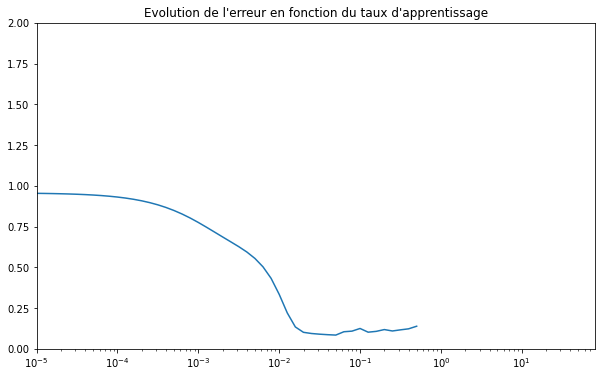

In [30]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 2])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [29]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [17]:
max_periodes = 1000

# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

def  My_MSE(y_true,y_pred):
  return(tf.keras.metrics.mse(y_true,y_pred)*std.numpy()+mean.numpy())
  
# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.05,
    decay_steps=10,
    decay_rate=0.1)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

# Entraine le modèle, avec une réduction des calculs du gradient
#historique = model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="loss")],batch_size=batch_size)

# Entraine le modèle sans réduction de calculs
historique = model.fit(dataset,validation_data=dataset_val, epochs=max_periodes,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 10, term="loss")],batch_size=batch_size)


Epoch 1/1000
41/41 [==============================] - 5s 85ms/step - loss: 0.6259 - mse: 0.6259 - val_loss: 0.5019 - val_mse: 0.5019

Epoch 00001: loss improved from inf to 0.41042, saving model to poids_train.hdf5
Epoch 2/1000
41/41 [==============================] - 3s 73ms/step - loss: 0.3406 - mse: 0.3406 - val_loss: 0.0882 - val_mse: 0.0882

Epoch 00002: loss improved from 0.41042 to 0.23213, saving model to poids_train.hdf5
Epoch 3/1000
41/41 [==============================] - 3s 74ms/step - loss: 0.1133 - mse: 0.1133 - val_loss: 0.0977 - val_mse: 0.0977

Epoch 00003: loss improved from 0.23213 to 0.10318, saving model to poids_train.hdf5
Epoch 4/1000
41/41 [==============================] - 3s 74ms/step - loss: 0.0865 - mse: 0.0865 - val_loss: 0.0969 - val_mse: 0.0969

Epoch 00004: loss improved from 0.10318 to 0.09233, saving model to poids_train.hdf5
Epoch 5/1000
41/41 [==============================] - 3s 70ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0900 - val_mse: 0.

In [18]:
model.load_weights('poids_train.hdf5')

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

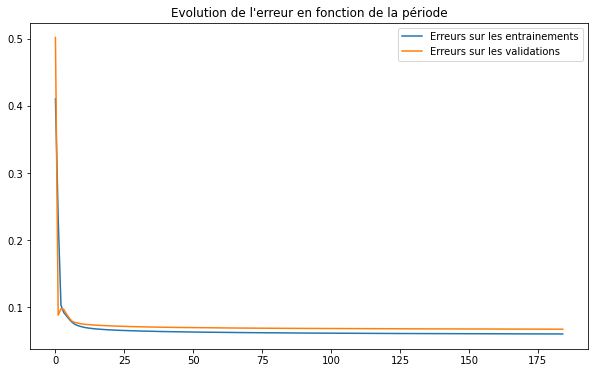

In [19]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [20]:
# Evaluation du modèle

model.evaluate(dataset)
model.evaluate(dataset_val)


10/10 [==============================] - 1s 60ms/step - loss: 0.0673 - mse: 0.0673


[0.06734878569841385, 0.06734878569841385]

**3. Prédictions**

In [21]:
# Création des instants d'entrainement et de validation
y_train_timing = serie_entrainement.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_train)]
y_val_timing = serie_test.index[taille_fenetre + horizon - 1:taille_fenetre + horizon - 1+len(y_val)]

# Calcul des prédictions
pred_ent = model.predict(dataset)
pred_val = model.predict(dataset_val)

In [22]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbe originale
serie = np.concatenate([serie_entrainement,serie_test])
index = np.linspace(0,len(serie)-1,len(serie),dtype=np.int16)
fig.add_trace(go.Scatter(x=index,y=serie,line=dict(color='blue', width=1),name="Série oroginale"))

# Courbes des prédictions d'entrainement
fig.add_trace(go.Scatter(x=index[taille_fenetre:],y=pred_ent[:,0],line=dict(color='green', width=1),name="Entrainement"))

# Courbe de validation
fig.add_trace(go.Scatter(x=index[temps_separation+taille_fenetre:],y=pred_val[:,0],line=dict(color='red', width=1),name="Validation"))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()